# Reddit Flair Detector

---

## Part II - Exploratory Data Analysis (EDA)

### 1) Import required modules

In [1]:
import nltk
import string
import os
import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/abhiroop/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/abhiroop/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/abhiroop/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/abhiroop/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/abhiroop/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/abhiroop/nltk_data...
[nltk_data]    |   Package movie_reviews is a

True

### 2) Read and load raw data CSV

In [2]:
raw_data = pd.read_csv("../data/reddit_raw_data.csv")
raw_data.head()

,flair,title,score,id,author,comms_num,body,url
0,Scheduled,"Untouchability, even in quarantine. 'We have n...",52,fzvwz8,sam-sepiol,7,NaN,https://www.telegraphindia.com/india/coronavir...
1,Scheduled,Delhi Govt Sources: Names of CM Arvind Kejriwa...,301,f7ogd8,The_andh_bhakth,30,NaN,https://twitter.com/ANI/status/123109390051893...
2,Scheduled,"Delhi: AP Singh, advocate of 2012 Delhi gang-r...",17,flgvah,devCR7,21,NaN,https://twitter.com/ani/status/124073128907587...
3,Scheduled,Why the Supreme Court’s verdict on SC/ST quota...,110,f1o839,rahulthewall,47,NaN,https://scroll.in/article/952687/why-the-supre...
4,Scheduled,What about the entrance exams scheduled in May?,8,fvcvo1,plsacceptmyusername,3,"CLAT, AILET, NEET, JEE have been postponed bu...",https://www.reddit.com/r/india/comments/fvcvo1...


### 3) Removing ```nan``` elements from ```body```

* Some rows in the ```body``` column are empty and need to be replaced with empty string so that classifiers can perform properly
> For example: If we don't remove undefined rows, while training a Naive Bayes Classifier, we encounter a ```ValueError: np.nan is an invalid document, expected byte or unicode string``` error 

* Therefore, we first check number of such rows and them replace them

In [3]:
raw_data['body'] = raw_data['body'].astype(str)
invalid_list = ["nan", "[deleted]", "[removed]", "deleted", "removed"]

for x in invalid_list:
    print("Number of", x, "elements:", len(raw_data[raw_data['body'] == x]))

Number of nan elements: 1132
Number of [deleted] elements: 0
Number of [removed] elements: 0
Number of deleted elements: 0
Number of removed elements: 0


In [4]:
raw_data['body'] = raw_data['body'].apply(lambda x: '' if x in invalid_list else x)
raw_data['body'] = raw_data['body'].apply(lambda x: '' if x in invalid_list else x)

for x in invalid_list:
    print("Number of", x, "elements:", len(raw_data[raw_data['body'] == x]))

Number of nan elements: 0
Number of [deleted] elements: 0
Number of [removed] elements: 0
Number of deleted elements: 0
Number of removed elements: 0


In [5]:
raw_data.head()

,flair,title,score,id,author,comms_num,body,url
0,Scheduled,"Untouchability, even in quarantine. 'We have n...",52,fzvwz8,sam-sepiol,7,,https://www.telegraphindia.com/india/coronavir...
1,Scheduled,Delhi Govt Sources: Names of CM Arvind Kejriwa...,301,f7ogd8,The_andh_bhakth,30,,https://twitter.com/ANI/status/123109390051893...
2,Scheduled,"Delhi: AP Singh, advocate of 2012 Delhi gang-r...",17,flgvah,devCR7,21,,https://twitter.com/ani/status/124073128907587...
3,Scheduled,Why the Supreme Court’s verdict on SC/ST quota...,110,f1o839,rahulthewall,47,,https://scroll.in/article/952687/why-the-supre...
4,Scheduled,What about the entrance exams scheduled in May?,8,fvcvo1,plsacceptmyusername,3,"CLAT, AILET, NEET, JEE have been postponed bu...",https://www.reddit.com/r/india/comments/fvcvo1...


### 4) Cleaning with NLTK

> I had initially cleaned the text with [```cleantext```](https://pypi.org/project/clean-text/) but the LSTM models were not able to converge or attain acceptable accuracy then. Hence, I've removed that part of my pre-processing and used NLTK instead 


* The Natural Language Toolkit is a python library written for working and modeling text
* It provides good tools for loading and cleaning text that we can use to get our data ready for working with machine learning and deep learning algorithms
* We first remove punctuations like commas and quotes
* One way would be to split the document into words by white space, then use string translation to replace all punctuation with nothing 
* Python provides a constant called ```string.punctuation``` that provides a great list of punctuation characters
* Python offers a function called ```translate()``` that will map one set of characters to another
* We can use the function ```maketrans()``` to create a mapping table. We can create an empty mapping table, but the third argument of this function allows us to list all of the characters to remove during the translation process
* Then we filter out stop words. Stop words are those words that do not contribute to the deeper meaning of the phrase
* The most common words are: “the“, “a“, and “is“ etc.


In [6]:
no_punc_titles = []
rem_sw = []

def nltk_clean(field):
    # remove punctuation from each word
    for title in raw_data[field]:
        words = title.split(" ")
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in words]
        no_punc_titles.append(' '.join(stripped))


    # filter out stop words
    for title in no_punc_titles:
        words = title.split(" ")
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        rem_sw.append(' '.join(words))

nltk_clean('title')
raw_data['title'] = rem_sw

### 5) Repeating step 4 for ```body``` text

In [7]:
no_punc_titles = []
rem_sw = []

nltk_clean('body')
raw_data['body'] = rem_sw

In [8]:
raw_data.head()

,flair,title,score,id,author,comms_num,body,url
0,Scheduled,Untouchability even quarantine We never taken ...,52,fzvwz8,sam-sepiol,7,,https://www.telegraphindia.com/india/coronavir...
1,Scheduled,Delhi Govt Sources Names CM Arvind Kejriwal De...,301,f7ogd8,The_andh_bhakth,30,,https://twitter.com/ANI/status/123109390051893...
2,Scheduled,Delhi AP Singh advocate 2012 Delhi gangrape co...,17,flgvah,devCR7,21,,https://twitter.com/ani/status/124073128907587...
3,Scheduled,Why Supreme Court’s verdict SCST quotas create...,110,f1o839,rahulthewall,47,,https://scroll.in/article/952687/why-the-supre...
4,Scheduled,What entrance exams scheduled May,8,fvcvo1,plsacceptmyusername,3,CLAT AILET NEET JEE postponed two weeks Would...,https://www.reddit.com/r/india/comments/fvcvo1...


### 6) Plot a WordCloud for ```title```

* This helps us to find out the most common words in the ```title``` column
* We see that *coronavirus* and *india* are one of the most recurring words

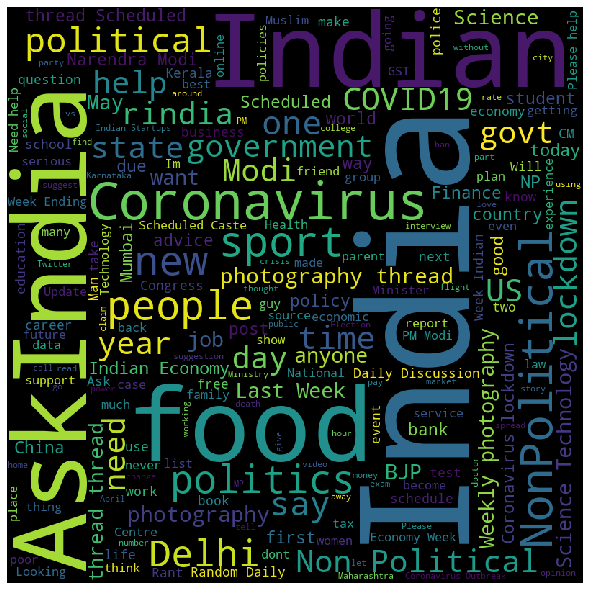

In [9]:
comment_words = " "
for val in raw_data['title']: 
    val = str(val) 
    tokens = val.split() 
    for words in tokens:
        comment_words = comment_words + words + ' '
        

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 7) Top Unigrams and Bigrams

* In the context of text corpora, n-grams refer to sequences of words
* A unigram is one word, a bigram is a sequence of two words, a trigram is a sequence of three words etc
* The items inside an n-gram may not have any relation between them apart from the fact that they appear next to each other
* We can see from the n-grams that the top posts are related to the Indian Economy and Coronavirus. Which is understandable given the current situation

In [10]:
def get_top_n_words(corpus, size, n=None):
    vec = CountVectorizer(ngram_range=size, stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("Top unigrams:\n")
common_words = get_top_n_words(raw_data['title'], (1,1), 20)
for word, freq in common_words:
    print(word, freq)

print("\nTop bigrams:\n")
common_words = get_top_n_words(raw_data['title'], (2,2), 20)
for word, freq in common_words:
    print(word, freq)

Top unigrams:

india 460
coronavirus 271
indian 219
food 201
askindia 174
thread 149
nonpolitical 147
political 144
photography 134
people 97
lockdown 97
scheduled 96
modi 94
sports 90
help 87
economy 84
politics 84
delhi 80
week 80
science 75

Top bigrams:

non political 52
photography thread 45
weekly photography 42
science technology 39
thread thread 36
indian economy 36
coronavirus lockdown 31
daily discussion 27
random daily 26
narendra modi 24
week indian 24
economy week 22
week ending 22
pm modi 18
need help 17
indian startups 17
startups week 17
coronavirus outbreak 15
food delivery 14
discussion thread 12


### 8) Save cleaned data to CSV file


In [11]:
cleaned_data = pd.DataFrame(raw_data,columns=["flair","title","score","id","author","comms_num","body","url"])
cleaned_data.to_csv('../data/reddit_cleaned_data.csv', index=False)